## Importing Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense,Dropout, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from scipy.ndimage import zoom

from joblib import Parallel, delayed

from tensorflow.keras.models import load_model

## PreProcessing RAVDESS and SURREY Dataset

In [2]:
paths = ['Confidence_Dataset','RAVDESS','SURREY','ALL']

mainPath = os.path.join(paths[0],paths[1])
actor_folders = os.listdir(mainPath)

emotion_dict = {
    1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',
    6:'fearful',7:'disgust',8:'surprise',
    'a':'angry','d':'disgust','f':'fearful',
    'h':'happy','n':'neutral','sa':'sad',
    'su':'surprise'
    
}

X_val = []
y_val = []

emotions =[emotion_dict[i] for i in range(1,9)] # these are only the 8 unique emotions
emotion_freq = np.array([0 for i in range(0,8)],dtype = int)
emotion_paths = []
emotion_name = []
for actor_folder in actor_folders:
    newPath = os.path.join(mainPath,actor_folder)
    audioFiles = os.listdir(newPath)
    for audioFile in audioFiles:
        new_audio_path = os.path.join(newPath,audioFile)
        emotion = audioFile[6:8]# text part of the files that contains the emotion code
        emotion_paths.append(new_audio_path)
        emotion_name.append(emotion_dict[int(emotion)])
        
surrey_folder = os.path.join(paths[0],paths[2],paths[3])
audioFiles = os.listdir(surrey_folder)
for audioFile in audioFiles:
    newPath = os.path.join(surrey_folder,audioFile)
    emotion = audioFile[3:5]# label part for emotion
    emotion_paths.append(newPath)
    if(emotion[0]!='s'):
        emotion_name.append(emotion_dict[emotion[0]])
    else:
        emotion_name.append(emotion_dict[emotion])
    

emotion_freq = [emotion_name.count(emotion_dict[i]) for i in range(1,9)]

emotion_info = pd.DataFrame({
    'emotion':emotions,
    'frequency':emotion_freq
}
)

emotion_label_df = pd.DataFrame(
    {
        'label':emotion_name,
        'path': emotion_paths
    }
)

In [3]:
emotion_label_df.head()

,label,path
0,neutral,Confidence_Dataset\RAVDESS\Actor_01\03-01-01-0...
1,neutral,Confidence_Dataset\RAVDESS\Actor_01\03-01-01-0...
2,neutral,Confidence_Dataset\RAVDESS\Actor_01\03-01-01-0...
3,neutral,Confidence_Dataset\RAVDESS\Actor_01\03-01-01-0...
4,calm,Confidence_Dataset\RAVDESS\Actor_01\03-01-02-0...


### Dataset Spread

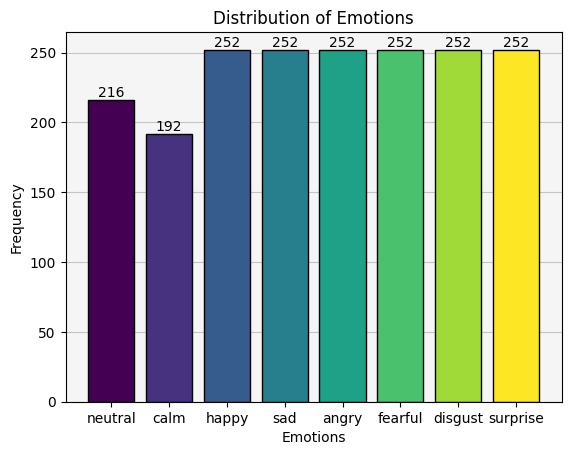

In [4]:
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.grid(axis='y',linestyle='-', alpha = 0.7, zorder= 0)
plt.gca().set_facecolor('#f5f5f5')

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0,1,len(emotion_info['frequency'])))



bars = plt.bar(emotion_info['emotion'],emotion_info['frequency'],color = colors, zorder=2,edgecolor='black')
counter =0
for bar in bars:
    height = bar.get_height()
    countVal = emotion_info['frequency'][counter]
    plt.text(bar.get_x()+bar.get_width()/2.0, height,f'{countVal}',ha='center',va='bottom')
    counter+=1

plt.show()

## Extracting Features

In [5]:
class FeatureExtract:
    def __init__(self,frame_length=2048,hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length
    def zcr(self,data):
        return librosa.feature.zero_crossing_rate(data,frame_length = self.frame_length, hop_length = self.hop_length).flatten()
    def rmse(self,data):
        return librosa.feature.rms(y=data,frame_length = self.frame_length, hop_length = self.hop_length).flatten()
    def mfcc(self, data,sr, n_mfcc=13, flatten = True):
        mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc = n_mfcc, hop_length= self.hop_length)
        return mfcc_features.T.flatten() if flatten else mfcc_features.T
    def chroma(self,data,sr):
        chroma_features = librosa.feature.chroma_stft(y=data,sr=sr,hop_length = self.hop_length)
        return chroma_features.T.flatten()
    def spectral_contrast(self,data,sr):
        contrast_features = librosa.feature.spectral_contrast(y=data,sr=sr,hop_length=self.hop_length)
        return contrast_features.T.flatten()
    def mel_spectrogram(self, data,sr):
        mel_features = librosa.feature.melspectrogram(y=data,sr=sr,hop_length = self.hop_length)
        return librosa.power_to_db(mel_features).flatten()
    def extract_features(self,data,sr):
        zcr_features = self.zcr(data)
        rmse_features = self.rmse(data)
        mfcc_features = self.mfcc(data,sr)
        chroma_features = self.chroma(data,sr)
        spectral_contrast_features = self.spectral_contrast(data,sr)
        mel_spectrogram_features = self.mel_spectrogram(data,sr)
        return np.concatenate(
            [
                zcr_features,
                rmse_features,
                mfcc_features,
                chroma_features,
                spectral_contrast_features,
                mel_spectrogram_features
            ]
        )

## Data Augmentation

In [6]:
class DataAugmentation:
    @staticmethod
    def noise(data, noise_factor=0.005):
        noise_amp = noise_factor * np.random.uniform() * np.amax(data)
        return data + noise_amp * np.random.normal(size=data.shape[0])

    @staticmethod
    def pitch(data, sr, n_steps=4):
        return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

## Reading Audio Files

In [7]:
class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.feature_extractor = FeatureExtract(frame_length, hop_length)
        self.augmenter = DataAugmentation()

    def get_features(self, path, duration=2.5, offset=0.6):
        data, sr = librosa.load(path, duration=duration, offset=offset)
        features = [self.feature_extractor.extract_features(data, sr)]
        
        noised_audio = self.augmenter.noise(data)
        features.append(self.feature_extractor.extract_features(noised_audio, sr))

        pitched_audio = self.augmenter.pitch(data, sr)
        features.append(self.feature_extractor.extract_features(pitched_audio, sr))

        pitched_noised_audio = self.augmenter.noise(pitched_audio)
        features.append(self.feature_extractor.extract_features(pitched_noised_audio, sr))

        return np.array(features)

    def process_feature(self, path, emotion):
        features = self.get_features(path)
        X = features.tolist()
        Y = [emotion] * len(features)
        return X, Y

    def process_dataset(self, df, n_jobs=-1):
        paths = df['path'].values
        emotions = df['label'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.extend(result[0])
            Y.extend(result[1])

        # Padding or truncating sequences to the same length
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)


processor = AudioProcessor()

In [16]:
X, y = processor.process_dataset(emotion_label_df) # if data not available then call this

def normalize(val,min_val,range_val):
    return (val-min_val) / range_val
    
min_vals = [np.min(X[i]) for i in range(0,X.shape[0])]
max_vals = [np.max(X[i]) for i in range(0,X.shape[0])]
ranges_val = [max_vals[i] - min_vals[i] for i in range(0,len(min_vals))]

for i in range(X.shape[0]): # my own normalization method
    X[i] = np.array([normalize(X[i][c],min_vals[i],ranges_val[i]) for c in range(X.shape[1])])
# scaler = RobustScaler()
# X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y,num_classes = 8)

np.savez(os.path.join('ProcessedData','X_y.npz'), Inputs=X, Labels=y) # commented cause already saved pre process data

for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i} -> {class_name}")


## Test Train Splits

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,
                                                       test_size = 0.1,
                                                       random_state=42)

In [19]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1,1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1,1))
X_valid = X_valid.reshape((X_valid.shape[0],X_valid.shape[1],1,1))

print(X_train.shape,X_test.shape,X_valid.shape)

(6220, 17496, 1, 1) (768, 17496, 1, 1) (692, 17496, 1, 1)


## Define the Model

In [20]:
def createModel(input_size, num_classes =8):
    num_filters = [24,32,64,128] 
    pool_size = (2, 1) 
    kernel_size = (3, 3)  
    keras.backend.clear_session()
    
    model = Sequential()
    model.add(Conv2D(16,kernel_size,input_shape= input_size, activation= 'relu', padding ='same'))
    model.add(MaxPooling2D(pool_size, padding ='same'))

    model.add(Conv2D(32,pool_size, activation= 'relu', padding ='same'))
    model.add(MaxPooling2D(pool_size, padding ='same'))

    model.add(Conv2D(64,kernel_size, activation= 'relu', padding ='same'))
    model.add(MaxPooling2D(pool_size, padding ='same'))

    model.add(Flatten())
    
    model.add(Dense(64, activation= 'relu')) 

    model.add(Dense(num_classes, activation="softmax"))
    
    return model


In [21]:
model = createModel(X_train[0].shape,8)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 17496, 1, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8748, 1, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8748, 1, 32)         │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4374, 1, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4374, 1, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2187, 1, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 139968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       8,958,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,978,248 (34.25 MB)

 Trainable params: 8,978,248 (34.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,epochs=100,
                    batch_size=16,validation_data=(X_valid,y_valid))

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_loss)
print(test_accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9004 - loss: 0.5167
0.5229227542877197
0.90625


In [31]:
model.save('SelfNormalizationModel.keras') # optional If you want to save

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)